In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

### Create network of communications

In [2]:
path = 'Sender-receiver-weight.csv'
sendReceiverdf = pd.read_csv(path)

In [3]:
sendReceiverdf

,Sender,Receiver,Weight
0,Richard Shapiro,Leslie Lawner,2
1,Richard Shapiro,Sandra McCubbin,2
2,Richard Shapiro,Jeff Dasovich,97
3,Richard Shapiro,Linda Robertson,7
4,Richard Shapiro,Paul Kaufman,7
...,...,...,...
4503,Benjamin Rogers,Randall Martin,4
4504,Benjamin Rogers,Michelle Kelso,2
4505,Kerri Thompson,Kate Symes,684
4506,Kerri Thompson,Carla Hoffman,15


In [4]:
import networkx as nx

G_comm = nx.DiGraph()


for idx, row in sendReceiverdf.iterrows():
    G_comm.add_edge(row['Sender'], row['Receiver'], weight=row['Weight'])

In [5]:
G_comm

### Create the network of similarity of communications

In [6]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [7]:
senderTextdf

,Unnamed: 0,Sender,All texts
0,0,Kerri Thompson,think price deal ; missing deal jeff richter s...
1,1,Chris Germany,nan; De Man change spelling Druckett Dracut ow...
2,2,Evelyn Metoyer,Hi Kate Mike Swerzbin ref Prebon counterparty ...
3,3,Gerald Nemec,Attached form; Attached form; Article relevant...
4,4,Tana Jones,connection execution new ISDA Master Agreement...
5,5,Mark E Haedicke,efficiently EWS Mark Forwarded Mark E Haedick...
6,6,James D Steffes,Jeff helpful feedback prior starting deal fun...
7,7,John J Lavorato,Original Message From Guerriero Michael mailto...
8,8,Richard B Sanders,kidding Columbus day found PUC Jeff DasovichEN...
9,9,Richard Shapiro,Leslieafter seeing point writing extremely r...


In [7]:
# text in sender
text_list = senderTextdf['All texts'].tolist()
sender_list = senderTextdf['Sender'].tolist()

In [9]:
# Calculate the similarity between the abstracts using n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(text_list)
similarity_matrix = cosine_similarity(X, X)

In [10]:
# Create a graph from the similarity matrix
# Draw an edge between papers with similarity in the fourth quartile

# Calculate the 75th percentile of the similarity matrix
import numpy as np
percentile_75 = np.percentile(similarity_matrix, 75)
print(f"75th percentile = {percentile_75}")

G_sim = nx.Graph()
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > percentile_75:
            G_sim.add_edge(sender_list[i], sender_list[j])

75th percentile = 0.44058040025146533


In [11]:
# Save the graph to a CSV file
nx.write_edgelist(G_sim, 'similarity_graph_emailDataset.csv', delimiter=',')

In [14]:
# Not sure what this list is for. We need to use the sender_list, because it contains the nodes in both graphs
# unique_elements = list(set(sendReceiverdf['Sender'].tolist() + sendReceiverdf['Receiver'].tolist()))
# node_list = list(unique_elements)
# len(node_list)

### Calculate the intersection for every node

In [12]:
# Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
intersection_dict = {}
for node in sender_list:
    # Check if node is in both graphs
    # TODO: Figure out why some nodes are not in both graphs
    if node not in G_comm.nodes or node not in G_sim.nodes:
        print(f"Node '{node}' is not in both graphs")
        continue
    network_comm_neighbors = set(G_comm.neighbors(node))
    network_sim_neighbors = set(G_sim.neighbors(node))
    intersection = network_comm_neighbors.intersection(network_sim_neighbors)
    union = network_comm_neighbors.union(network_sim_neighbors)
    jaccard_similarity = len(intersection) / len(union)
    intersection_dict[node] = {
        'intersection': intersection,
        'union': union,
        'jaccard_similarity': jaccard_similarity
    }

# # Save the intersection dictionary to a JSON file
# with open('./data/intersection_dict.json', 'w') as f:
#     json.dump(intersection_dict, f, indent=4)

Node 'Benjamin Rogers' is not in both graphs
Node 'Carol St Clair' is not in both graphs


In [13]:
intersection_dict

{'Kerri Thompson': {'intersection': {'Kate Symes'},
  'union': {'Carla Hoffman', 'Evelyn Metoyer', 'Kate Symes'},
  'jaccard_similarity': 0.3333333333333333},
 'Chris Germany': {'intersection': set(),
  'union': {'Airam Arteaga',
   'Alex Perkins',
   'Alfonso Trabulsi',
   'Alicia Perkins',
   'Alvin Thompson',
   'Amy Ochoa',
   'Andrea Ring',
   'Angel Fuller',
   'Angie Zeman',
   'Anne Bertino',
   'Audrey Cook',
   'Barbara N Gray',
   'Beverly Beaty',
   'Bhavna Pandya',
   'Brad McKay',
   'Brandon Oliveira',
   'Brenda H Fletcher',
   'Briant Baker',
   'Bryce Baxter',
   'Cecilia Olvera',
   'Chad Gronvold',
   'Chris Germany',
   'Chris Meyer',
   'Chris Ordway',
   'Christopher Spears',
   'Cindy Vachuska',
   'Clayton Vernon',
   'Colin Tonks',
   'Colleen Sullivan',
   'Cora Pendergrass',
   'Crystal Hyde',
   'Cynthia Franklin',
   'Dan J Hyvl',
   'Dan Junek',
   'Dana Daigle',
   'Daren J Farmer',
   'Darla Saucier',
   'Dave Scott',
   'David Oliver',
   'David Wile',

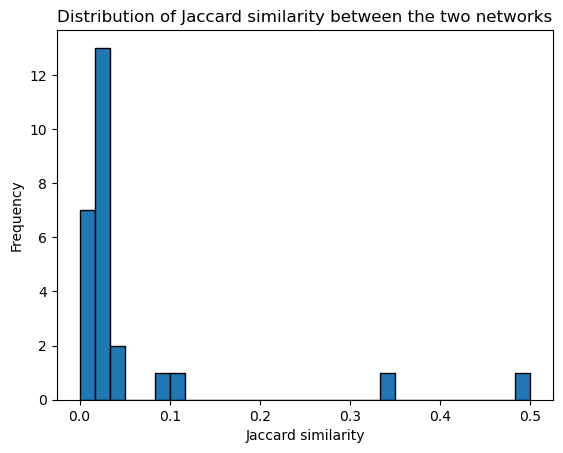

In [14]:
# Plot the distribution of the Jaccard similarity
jaccard_values = [value['jaccard_similarity'] for value in intersection_dict.values()]
fig, ax = plt.subplots()
ax.hist(jaccard_values, bins=30, edgecolor='black')
ax.set_xlabel('Jaccard similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Jaccard similarity between the two networks')
plt.show()

### Visualise networks

In [15]:
from matplotlib import patches
def visualise_sender_networks(selected_sender):

    # Get the neighbors of the selected sender in the two networks
    comm_neighbors = list(G_comm.neighbors(selected_sender))
    sim_neighbors = list(G_sim.neighbors(selected_sender))

    # Get the intersection
    intersection = set(comm_neighbors).intersection(set(sim_neighbors))
    only_comm = set(comm_neighbors).difference(set(sim_neighbors))
    only_sim = set(sim_neighbors).difference(set(comm_neighbors))

    G_vis = nx.Graph()
    for neighbor in only_comm:
        G_vis.add_edge(selected_sender, neighbor, network='communication')
    for neighbor in only_sim:
        G_vis.add_edge(selected_sender, neighbor, network='similarity')
    for neighbor in intersection:
        G_vis.add_edge(selected_sender, neighbor, network='both')

    # Visualise the graph
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G_vis)
    communication_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'communication']
    similarity_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'similarity']
    both_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'both']

    nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=communication_edges, ax=ax, edge_color='red')
    nx.draw_networkx_edges(G_vis, pos, edgelist=similarity_edges, ax=ax, edge_color='blue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')
    nx.draw_networkx_labels(G_vis, pos, ax=ax)

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')

    # Add a legend for edges only
    communication_patch = patches.Patch(color='red', label='Communication')
    similarity_patch = patches.Patch(color='blue', label='Similarity')
    both_patch = patches.Patch(color='green', label='Both')
    ax.legend(handles=[communication_patch, similarity_patch, both_patch])

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')
    
    plt.tight_layout()
    plt.show()

# Convert intersection dict into intersection tuple and find the unique names

In [16]:
# List to store tuples of nodes with non-empty intersections
intersections = []

# Iterate through the dictionary
for node, data in intersection_dict.items():
    if data['intersection']:
        # For each item in the intersection, create a tuple with the current node
        for intersect_node in data['intersection']:
            intersections.append((node, intersect_node))
print(intersections)


[('Kerri Thompson', 'Kate Symes'), ('Evelyn Metoyer', 'Kate Symes'), ('Gerald Nemec', 'Dan J Hyvl'), ('Gerald Nemec', 'Richard B Sanders'), ('Gerald Nemec', 'Susan Scott'), ('Gerald Nemec', 'Tana Jones'), ('Gerald Nemec', 'Mark Taylor'), ('Tana Jones', 'Dan J Hyvl'), ('Tana Jones', 'Steven J Kean'), ('Tana Jones', 'Mark E Haedicke'), ('Tana Jones', 'Richard B Sanders'), ('Tana Jones', 'Sara Shackleton'), ('Tana Jones', 'Elizabeth Sager'), ('Tana Jones', 'Mark Taylor'), ('Mark E Haedicke', 'Steven J Kean'), ('Mark E Haedicke', 'Jeffrey A Shankman'), ('Mark E Haedicke', 'Richard B Sanders'), ('Mark E Haedicke', 'Elizabeth Sager'), ('Mark E Haedicke', 'Mark Taylor'), ('Mark E Haedicke', 'Richard Shapiro'), ('James D Steffes', 'Richard Shapiro'), ('James D Steffes', 'Richard B Sanders'), ('James D Steffes', 'Jeff Dasovich'), ('James D Steffes', 'Steven J Kean'), ('Richard B Sanders', 'Steven J Kean'), ('Richard B Sanders', 'Mark E Haedicke'), ('Richard B Sanders', 'Gerald Nemec'), ('Richar

In [17]:
def find_unique_names(tuples):
 unique_names = set()
 for tuple in tuples:
   unique_names.update(tuple) 
 return list(unique_names)  
unique_names = find_unique_names(intersections)
print(unique_names)  

['Steven J Kean', 'Mark E Haedicke', 'Mike McConnell', 'Susan Scott', 'Tana Jones', 'Sara Shackleton', 'Elizabeth Sager', 'Dan J Hyvl', 'Evelyn Metoyer', 'Jeffrey A Shankman', 'Daren J Farmer', 'Kate Symes', 'Shirley Crenshaw', 'Maureen McVicker', 'John J Lavorato', 'Vince J Kaminski', 'Mark Taylor', 'Richard Shapiro', 'Sally Beck', 'Gerald Nemec', 'James D Steffes', 'Kerri Thompson', 'Kay Mann', 'Richard B Sanders', 'Jeff Dasovich']


# Counting lemma frequency

In [21]:
len(unique_names)

25

In [18]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



In [19]:
def get_lemmas(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return set(lemmas)


In [20]:
# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    
    # Find common lemmas across rows for the sender
    common_lemmas = set.intersection(*lemma_sets)
    
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas


In [29]:
len(lemmas_by_sender)

25

# Node semnatics simailrity

In [23]:
import spacy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

In [26]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import pandas as pd

nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /Users/mingshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mingshi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [32]:
# contains mutiple lingustic feature such synonyms
nlp = spacy.load("en_core_web_md")

In [33]:

lemmatizer = WordNetLemmatizer()

remove_words = {'cc', 'subject', 're', 'fwd', 'to', 'from'}

def preprocess_words(words):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in remove_words and word.lower() not in stopwords.words('english')]
    return " ".join(lemmatized_words)

processed_data = {key: preprocess_words(value) for key, value in lemmas_by_sender.items()}

def calculate_similarity(lemmas_by_sender):
    texts = list(lemmas_by_sender.values())
    docs = [nlp(text) for text in texts]
    vectors = [doc.vector for doc in docs]
    
    similarity_matrix = cosine_similarity(vectors)
    
    return pd.DataFrame(similarity_matrix, index=lemmas_by_sender.keys(), columns=lemmas_by_sender.keys())

similarity_df = calculate_similarity(processed_data)


In [34]:
similarity_df

,Steven J Kean,Mark E Haedicke,Mike McConnell,Susan Scott,Tana Jones,Sara Shackleton,Elizabeth Sager,Dan J Hyvl,Evelyn Metoyer,Jeffrey A Shankman,...,Vince J Kaminski,Mark Taylor,Richard Shapiro,Sally Beck,Gerald Nemec,James D Steffes,Kerri Thompson,Kay Mann,Richard B Sanders,Jeff Dasovich
Steven J Kean,1.000000,0.997102,0.994441,0.991892,0.992598,0.994350,0.993981,0.991077,0.942896,0.994542,...,0.995750,0.997207,0.993384,0.994731,0.993023,0.993112,0.865362,0.994472,0.996924,0.998160
Mark E Haedicke,0.997102,1.000000,0.993983,0.994569,0.991380,0.996512,0.995804,0.991154,0.942758,0.991849,...,0.995475,0.997155,0.995336,0.994285,0.988203,0.996469,0.863468,0.991380,0.998159,0.994373
Mike McConnell,0.994441,0.993983,1.000000,0.993670,0.994364,0.993828,0.996179,0.994790,0.962762,0.997981,...,0.996367,0.995844,0.995821,0.997777,0.994020,0.994009,0.895445,0.996041,0.992838,0.994789
Susan Scott,0.991892,0.994569,0.993670,1.000000,0.989230,0.992961,0.994579,0.992854,0.958556,0.989883,...,0.992040,0.993526,0.994649,0.991679,0.987226,0.998057,0.885278,0.993150,0.993268,0.993345
Tana Jones,0.992598,0.991380,0.994364,0.989230,1.000000,0.996945,0.996972,0.996780,0.961187,0.996286,...,0.994537,0.996928,0.990755,0.992931,0.997048,0.988211,0.897254,0.996691,0.994035,0.993716
Sara Shackleton,0.994350,0.996512,0.993828,0.992961,0.996945,1.000000,0.997611,0.995176,0.951507,0.993314,...,0.996505,0.998438,0.992380,0.993638,0.991939,0.993130,0.878926,0.993666,0.997174,0.993523
Elizabeth Sager,0.993981,0.995804,0.996179,0.994579,0.996972,0.997611,1.000000,0.997374,0.961447,0.995547,...,0.995293,0.997511,0.995507,0.995532,0.994349,0.994143,0.893433,0.995808,0.996827,0.993801
Dan J Hyvl,0.991077,0.991154,0.994790,0.992854,0.996780,0.995176,0.997374,1.000000,0.966648,0.995015,...,0.992345,0.995289,0.991502,0.993803,0.995728,0.990570,0.902234,0.997470,0.993380,0.993033
Evelyn Metoyer,0.942896,0.942758,0.962762,0.958556,0.961187,0.951507,0.961447,0.966648,1.000000,0.962465,...,0.948740,0.949933,0.959540,0.955848,0.959856,0.953392,0.973075,0.964279,0.947127,0.953542
Jeffrey A Shankman,0.994542,0.991849,0.997981,0.989883,0.996286,0.993314,0.995547,0.995015,0.962465,1.000000,...,0.996103,0.995913,0.993166,0.996736,0.996561,0.989825,0.896879,0.996693,0.992180,0.994905


In [35]:
nameindices = list(similarity_df.columns)

In [38]:
len(nameindices) 

25

In [39]:
# Remove self-comparisons by setting the diagonal to NaN
for i in range(len(similarity_df)):
    similarity_df.iat[i, i] = pd.NA

In [40]:
similarity_df

,Steven J Kean,Mark E Haedicke,Mike McConnell,Susan Scott,Tana Jones,Sara Shackleton,Elizabeth Sager,Dan J Hyvl,Evelyn Metoyer,Jeffrey A Shankman,...,Vince J Kaminski,Mark Taylor,Richard Shapiro,Sally Beck,Gerald Nemec,James D Steffes,Kerri Thompson,Kay Mann,Richard B Sanders,Jeff Dasovich
Steven J Kean,<NA>,0.997102,0.994441,0.991892,0.992598,0.99435,0.993981,0.991077,0.942896,0.994542,...,0.99575,0.997207,0.993384,0.994731,0.993023,0.993112,0.865362,0.994472,0.996924,0.99816
Mark E Haedicke,0.997102,<NA>,0.993983,0.994569,0.99138,0.996512,0.995804,0.991154,0.942758,0.991849,...,0.995475,0.997155,0.995336,0.994285,0.988203,0.996469,0.863468,0.99138,0.998159,0.994373
Mike McConnell,0.994441,0.993983,<NA>,0.99367,0.994364,0.993828,0.996179,0.99479,0.962762,0.997981,...,0.996367,0.995844,0.995821,0.997777,0.99402,0.994009,0.895445,0.996041,0.992838,0.994789
Susan Scott,0.991892,0.994569,0.99367,<NA>,0.98923,0.992961,0.994579,0.992854,0.958556,0.989883,...,0.99204,0.993526,0.994649,0.991679,0.987226,0.998057,0.885278,0.99315,0.993268,0.993345
Tana Jones,0.992598,0.99138,0.994364,0.98923,<NA>,0.996945,0.996972,0.99678,0.961187,0.996286,...,0.994537,0.996928,0.990755,0.992931,0.997048,0.988211,0.897254,0.996691,0.994035,0.993716
Sara Shackleton,0.99435,0.996512,0.993828,0.992961,0.996945,<NA>,0.997611,0.995176,0.951507,0.993314,...,0.996505,0.998438,0.99238,0.993638,0.991939,0.99313,0.878926,0.993666,0.997174,0.993523
Elizabeth Sager,0.993981,0.995804,0.996179,0.994579,0.996972,0.997611,<NA>,0.997374,0.961447,0.995547,...,0.995293,0.997511,0.995507,0.995532,0.994349,0.994143,0.893433,0.995808,0.996827,0.993801
Dan J Hyvl,0.991077,0.991154,0.99479,0.992854,0.99678,0.995176,0.997374,<NA>,0.966648,0.995015,...,0.992345,0.995289,0.991502,0.993803,0.995728,0.99057,0.902234,0.99747,0.99338,0.993033
Evelyn Metoyer,0.942896,0.942758,0.962762,0.958556,0.961187,0.951507,0.961447,0.966648,<NA>,0.962465,...,0.94874,0.949933,0.95954,0.955848,0.959856,0.953392,0.973075,0.964279,0.947127,0.953542
Jeffrey A Shankman,0.994542,0.991849,0.997981,0.989883,0.996286,0.993314,0.995547,0.995015,0.962465,<NA>,...,0.996103,0.995913,0.993166,0.996736,0.996561,0.989825,0.896879,0.996693,0.99218,0.994905


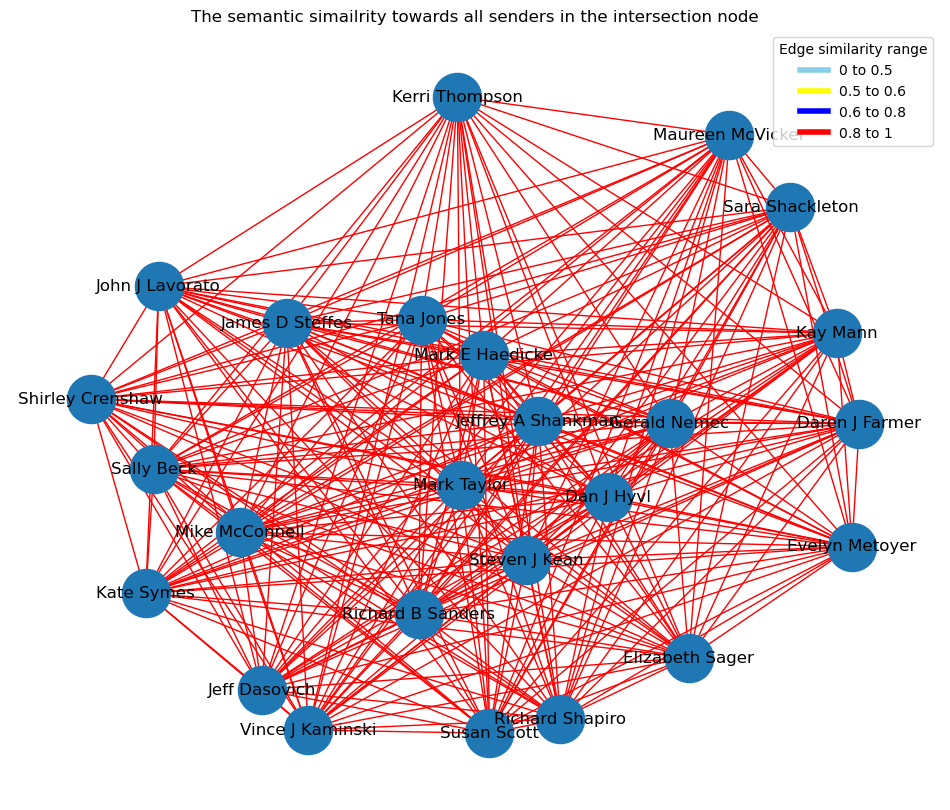

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.figure(figsize=(12, 10))
G = nx.Graph()

def get_edge_color(value):
    if value < 0.5:
        return 'skyblue'
    elif value < 0.6:
        return 'yellow'
    elif value < 0.8:
        return 'blue'
    else:
        return 'red'

# Add nodes and edges with the specified color based on similarity values
for source, targets in similarity_df.items():
    for target, value in targets.items():
        if source != target:  # Avoid self-comparison
            G.add_edge(source, target, color=get_edge_color(value), weight=value)

pos = nx.spring_layout(G_sim, k=2) 
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=1200)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color=[data['color'] for _, _, data in edges])

# Create a legend for the colors
legend_elements = [
    mlines.Line2D([0], [0], color='skyblue', lw=4, label='0 to 0.5'),
    mlines.Line2D([0], [0], color='yellow', lw=4, label='0.5 to 0.6'),
    mlines.Line2D([0], [0], color='blue', lw=4, label='0.6 to 0.8'),
    mlines.Line2D([0], [0], color='red', lw=4, label='0.8 to 1')
]
plt.legend(handles=legend_elements, loc='best',title="Edge similarity range")
plt.title("The semantic simailrity towards all senders in the intersection node")
plt.axis('off')
plt.savefig("semantic_similarity_network.png")
plt.axis('off')
plt.show()

# All sender lemma 

In [22]:
sender_lemmas = lemmas_by_sender

# Collect all lemmas from all senders
all_lemmas = set()
for lemmas in sender_lemmas.values():
    all_lemmas.update(lemmas)

# Count the frequency of each lemma across all senders
lemma_frequency = {}
for lemma in all_lemmas:
    count = sum(lemma in lemmas for lemmas in sender_lemmas.values())
    lemma_frequency[lemma] = count

sorted_lemmas = sorted(lemma_frequency.items(), key=lambda x: x[1], reverse=True)

print("Most to least common lemmas for all senders in the intersection node:")
for lemma, frequency in sorted_lemmas:
    print(f"{lemma}: {frequency}")


Most to least common lemmas for all senders in the intersection node:
great: 25
request: 25
service: 25
thing: 25
let: 25
point: 25
need: 25
week: 25
also: 25
way: 25
date: 25
want: 25
help: 25
sure: 25
told: 25
conference: 25
going: 25
number: 25
know: 25
afternoon: 25
think: 25
thanks: 25
say: 25
contact: 25
mind: 25
minute: 25
day: 25
friday: 25
price: 25
got: 25
time: 25
ok: 25
detail: 25
th: 25
mark: 25
wanted: 25
hour: 25
work: 25
change: 25
k: 25
pas: 25
message: 25
send: 25
heard: 25
sent: 25
fixed: 25
power: 25
check: 25
c: 25
term: 25
go: 25
trying: 25
energy: 25
buy: 25
im: 25
pm: 25
look: 25
risk: 25
yes: 25
talk: 25
add: 25
good: 25
thought: 25
mike: 25
april: 25
one: 25
status: 25
office: 25
jeff: 25
soon: 25
june: 25
left: 25
morning: 25
received: 25
yesterday: 25
schedule: 25
phone: 25
sorry: 25
subject: 25
month: 25
problem: 25
possible: 25
end: 25
interest: 25
cc: 25
like: 25
ill: 25
find: 25
said: 25
today: 25
email: 25
thank: 25
ask: 25
b: 25
following: 25
chris: 25

# Aggreate all sender leamma into a tuple

In [23]:
# Function to lemmatize a word
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

lemmatized_word_freq = [(lemmatize_word(word), freq) for word, freq in sorted_lemmas]

# Apply sentiment analysis to all senders' leamma followed by visualisation

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mingshi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Positive Words: ['great', 'want', 'help', 'sure', 'number', 'thanks', 'ok', 'energy', 'yes', 'good', 'interest', 'like', 'thank', 'free', 'fine', 'fyi', 'original', 'chance', 'happy', 'hope', 'best', 'certain', 'resolved', 'true', 'opportunity', 'agreed', 'agree', 'important', 'clear', 'create', 'support', 'allow', 'solution', 'well', 'better', 'agreement', 'approval', 'grant', 'credit', 'love', 'ready', 'appreciate', 'helpful', 'party', 'value', 'effective', 'ability', 'created', 'interested', 'pretty', 'kind', 'ensure', 'care', 'approved', 'fit', 'hopefully', 'please', 'benefit', 'huge', 'special', 'attachment', 'responsible', 'play', 'legal', 'easier', 'reliant', 'glad', 'natural', 'accept', 'share', 'join', 'asset', 'okay', 'prepared', 'increase', 'friend', 'recommend', 'apologize', 'challenge', 'holiday', 'appreciated', 'fun', 'significant', 'invite', 'reached', 'giving', 'commitment', 'interesting', 'advantage', 'save', 'wish', 'positive', 'strong', 'resolve', 'clean', 'successfu

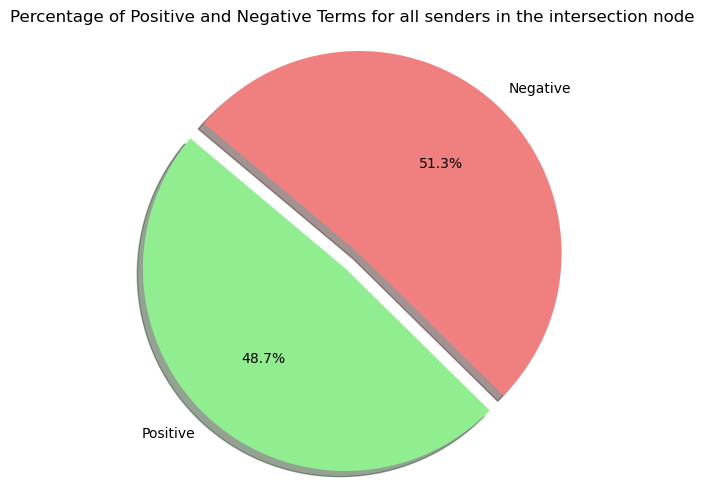

In [24]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')


word_freq =lemmatized_word_freq

sia = SentimentIntensityAnalyzer()


positive_words = []
negative_words = []
for word, _ in word_freq:
    sentiment_scores = sia.polarity_scores(word)
    if sentiment_scores['compound'] >= 0.05:
        positive_words.append(word)
    elif sentiment_scores['compound'] <= -0.05:
        negative_words.append(word)

total_count = sum(freq for _, freq in word_freq)
positive_percentage = (len(positive_words) / total_count) * 100
negative_percentage = (len(negative_words) / total_count) * 100


print("Positive Words:", positive_words)
print("Negative Words:", negative_words)

labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Percentage of Positive and Negative Terms for all senders in the intersection node')

plt.show()


# Individual node sentimental analysis

In [25]:
# Collect lemmas from all rows for each sender
lemmas_by_sender = {}

# Iterate through the list of names
for name in unique_names:
    print(name)
    # Query DataFrame to find rows with matching sender name
    matched_rows = senderTextdf[senderTextdf['Sender'] == name]
    lemma_sets = []
    
    # Iterate through matched rows to collect lemma sets
    for _, row in matched_rows.iterrows():
        text = row['All texts']
        lemma_sets.append(get_lemmas(text))
    # Store common lemmas for the sender
    lemmas_by_sender[name] = common_lemmas


Dan J Hyvl
Gerald Nemec
Elizabeth Sager
Maureen McVicker
Sally Beck
Shirley Crenshaw
John J Lavorato
Kerri Thompson
Kay Mann
Evelyn Metoyer
Susan Scott
Mark E Haedicke
Richard B Sanders
Vince J Kaminski
Sara Shackleton
Steven J Kean
James D Steffes
Mark Taylor
Kate Symes
Richard Shapiro
Mike McConnell
Jeff Dasovich
Tana Jones
Daren J Farmer
Jeffrey A Shankman


In [26]:
import csv
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def classify_attitude(lemmas):
    positive_count = 0
    negative_count = 0
    for lemma in lemmas:
        sentiment_scores = sia.polarity_scores(lemma)
        if sentiment_scores['compound'] >= 0.05:
            positive_count += 1
        elif sentiment_scores['compound'] <= -0.05:
            negative_count += 1
    
    total_count = len(lemmas)
    positive_percentage = (positive_count / total_count) * 100
    if positive_percentage > 50:
        return 'positive'
    else:
        return 'negative'

In [27]:

sender_attitudes = {}
for sender, lemmas in sender_lemmas.items():
    attitude = classify_attitude(lemmas)
    sender_attitudes[sender] = attitude

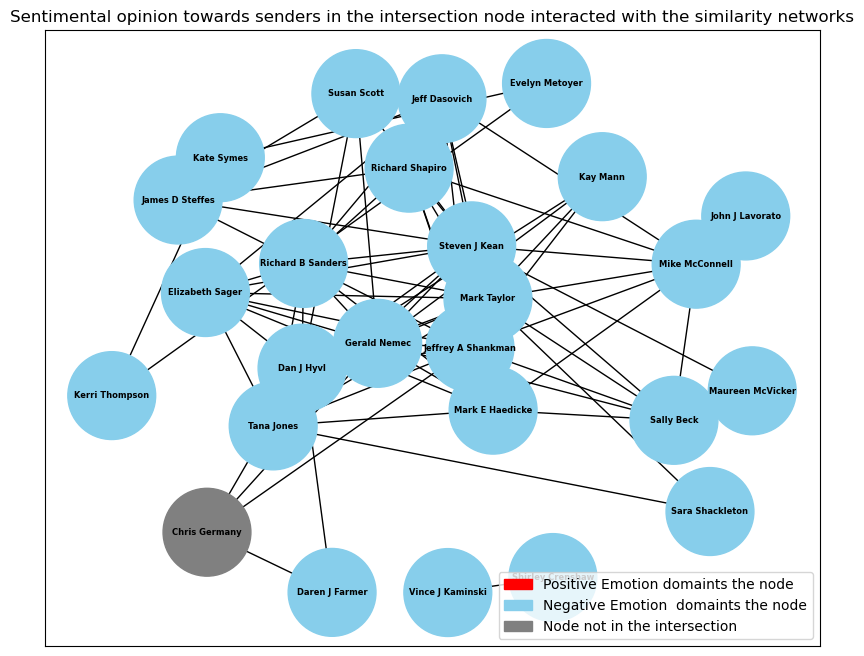

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sender_sentiment = sender_attitudes
node_colors = {'positive': 'red', 'negative': 'skyblue'}
node_color = []
for node in G_sim.nodes():
    if node in sender_sentiment:
        node_color.append(node_colors.get(sender_sentiment[node], 'gray'))
    else:
        node_color.append('gray')  

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_sim, k=1.8)  
nx.draw_networkx(G_sim, pos=pos, with_labels=True, node_color=node_color, node_size=4000, font_size=6, font_weight='bold')
red_patch = mpatches.Patch(color='red', label='Positive Emotion domaints the node')
blue_patch = mpatches.Patch(color='skyblue', label='Negative Emotion  domaints the node')
gray_patch = mpatches.Patch(color='gray', label='Node not in the intersection')  # Grey color for nodes not in the intersection
plt.legend(handles=[red_patch, blue_patch, gray_patch], loc='lower right')

plt.title('Sentimental opinion towards senders in the intersection node interacted with the similarity networks')
plt.savefig("sentiment_similarity_network.png", format="PNG")  # Save the figure
plt.show()
